In [1]:
import pandas as pd
import re
import numpy as np
from nltk.corpus import stopwords
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [6]:
#Clean the text:
def clean_chat(s):
    s = str(s)
    s = s.lower()                   #remove caps to avoid double words
    s = re.sub('<.+>', ' ', s)      #remove html format text
    s = re.sub('[\W\d]', ' ', s)    #remove special signs, punctuation, numbers
    s = re.sub(' +', ' ', s)        #remove excessive spaces
    s = s.strip()                   #remove first and last spaces
    return s

def spacy_lem(l):
    doc = nlp(l)
    return [token.lemma_ for token in doc]

import spacy
#I'll use spacy as it seemed like a good option to lemmatize with the appropriate pos tag, detects pronouns and superlative 
#forms of words.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

stop_words = list(stopwords.words('english'))
stop_words.append('-PRON-') #remove it as it won't be necessary in our model
stop_words.append('p')
stop_words.append('nbsp') #this is the '<p>' and &nbsp from the html conversion

In [7]:
chatc1 = pd.read_csv('../data/counsel-chat.txt')
chatc2 = pd.read_csv('../data/scrap-counsel-chat.txt') 

chatc1.drop(['questionID','questionUrl','therapistName','therapistUrl','upvotes'], axis=1, inplace=True)
chatc2.drop(['Unnamed: 0','questionID','questionLink','therapistInfo','therapistURL','upvotes','views','split'], axis=1, inplace=True)

chatc1.rename(columns={'topics':'topic'}, inplace=True)

counsel_cat = pd.concat([chatc1, chatc2])

counsel_cat['sentence'] = counsel_cat.questionTitle.fillna('') +' '+ counsel_cat.questionText.fillna('') +' '+ counsel_cat.answerText.fillna('')
counsel_cat.drop(['questionTitle', 'questionText', 'answerText'], axis=1, inplace=True)

counsel_cat.topic = counsel_cat.topic.apply(lambda x: str(x).lower())
counsel_cat.topic = counsel_cat.topic.apply(lambda x: str(x).strip())

counsel_cat.replace('nan', np.nan, inplace=True)
counsel_cat.dropna(inplace=True)

counsel_cat.replace('-', ' ', regex=True, inplace=True)

topic = counsel_cat.topic.unique()
topic = [str(word).split(',') for word in topic]
topic = [word for lst in topic for word in lst]
#Ok that's a lot of topics, let's try to reduce them not by deleting but make some topics more general
topic = np.unique(topic)

"""
- Substance abuse and Addiction are related topics -> ADDICTION,
- Anxiety and stress are realted topics -> STRESS,
- Relationships, social relationships, relationship dissolution, Marriage are related topics -> RELATIONSHIPS,
- Children and Adolescents, Family Conflict, Parenting, Alzheimer's are related topics -> FAMILY,
- Career Counseling, Professional Ethics, Workplace Relationship are related topics -> WORKPLACE,
- Human Sexuality and Intimacy -> SEXUALITY
- Counseling fundamentals, Legal & Regulatory, Military Issues and Diagnosis -> COUNSELING
- Behaviorall change, anger management -> BEHAVIOR

'SPIRITUALITY' = 0
'COUNSELING' = 1

'WORKPLACE' = 2
'FAMILY' = 3
'RELATIONSHIPS' = 4
'SLEEP' = 5
'BEHAVIOR' = 6
'SEXUALITY' = 7
'SELF_ESTEEM' = 8
'GRIEF' = 9
'TRAUMA' = 10

'STRESS' = 11
'EATING_DISORDERS' = 12
'ADDICTION' = 13
'DEPRESSION' = 14
'LGBTQ' = 15

'DOMESTIC_VIOLENCE' = 16
'SELF_HARM' = 17
"""

topic_dict = {'addiction':'13',
              "alzheimer's":'3',
              'anger management':'6',
              'anxiety':'11',
              'behavioral change':'6',
              'career counseling':'2',
              'children & adolescents':'3',
              'children adolescents':'4',
              'counseling fundamentals':'1',
              'depression':'14',
              'diagnosis':'1',
              'domestic violence':'16',
              'eating disorders':'12',
              'family conflict':'3',
              'grief and loss':'9',
              'human sexuality':'7',
              'intimacy':'7',
              'lgbtq':'15',
              'legal & regulatory':'1',
              'legal regulatory':'1',
              'marriage':'4',
              'military issues':'1',
              'parenting':'3',
              'professional ethics':'2',
              'dissolution':'4',
              'relationships':'4',
              'relationship':'4',
              'self esteem':'8',
              'self harm':'17',
              'sleep improvement':'5',
              'social':'4',
              'spirituality':'0',
              'stress':'11',
              'substance abuse':'13',
              'trauma':'10',
              'workplace':'2'}

for key in topic_dict:
    counsel_cat.topic = counsel_cat.topic.str.replace(key, topic_dict[key], regex=False)

#topic_red = counsel_cat.topic.unique()

def sort_topics(s):
    s = str(s)
    s = re.findall('\d+', s)
    s = [int(number) for number in s]
    return max(s)  

#sort_topics(counsel_cat.topic[1])

counsel_cat.topic = counsel_cat.topic.apply(sort_topics)

counsel_cat

,topic,sentence
0,3,Escalating disagreements between mother and wi...
1,13,I'm addicted to smoking. How can I stop? I'm p...
2,3,Keeping secrets from my family I have secrets ...
3,6,The Underlying Causes of Being Possessive I am...
4,11,Can I control anxiety without medication? I ha...
...,...,...
2124,1,What happens in a counseling session? After fi...
2125,1,What happens in a counseling session? After fi...
2126,1,What happens in a counseling session? After fi...
2127,1,What happens in a counseling session? After fi...


In [8]:
counsel_cat.sentence = counsel_cat.sentence.apply(clean_chat)
counsel_cat.sentence = counsel_cat.sentence.apply(spacy_lem)

counsel_cat.sentence = counsel_cat.sentence.apply(lambda x: np.unique([word for word in x if word not in stop_words]))

all_sentence = list(counsel_cat.sentence)
bow_sentence = [word for lst in all_sentence for word in lst]
all_words = nltk.FreqDist(bow_sentence)

#Get 3000 most common words
word_tuples = all_words.most_common(1000)
word_features = [x[0] for x in word_tuples]

#word_tuples
word_features

def vectorize_topic(l):
    new_list = []
    for word in word_features:
        if word in l:
            new_list.append(1)
        else:
            new_list.append(0)
    return new_list

counsel_cat.sentence = counsel_cat.sentence.apply(vectorize_topic)

In [9]:
word_features_df = pd.DataFrame(word_features)
word_features_df.to_csv('../data/word_features_topic.csv', index=False)

In [10]:
all_words
wordcloud_df = pd.DataFrame.from_dict(all_words, orient='index')
wordcloud_df

,0
back,430
cause,234
complain,35
difference,83
disagreement,10
...,...
liking,1
collect,1
reserved,1
targette,1


In [11]:
counsel_cat.reset_index(inplace=True)
counsel_cat.to_json('../data/counsel_text_1000.json')

In [12]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import json

In [13]:
counsel = counsel_cat.sample(frac=1)

X = counsel.sentence
y = counsel.topic

X_train = np.vstack(X[:3000])
X_test = np.vstack(X[3000:])

y_train = y[:3000]
y_test = y[3000:]

In [47]:
model = tf.keras.models.Sequential()
#model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(1000, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(800, activation = tf.nn.relu))

model.add(tf.keras.layers.Dense(18, activation = tf.nn.softmax))

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(X_train, y_train, epochs=8)

Epoch 1/8
94/94 [==============================] - 1s 11ms/step - loss: 1.5607 - accuracy: 0.5360
Epoch 2/8
94/94 [==============================] - 1s 10ms/step - loss: 0.4414 - accuracy: 0.8707
Epoch 3/8
94/94 [==============================] - 1s 10ms/step - loss: 0.2010 - accuracy: 0.9350
Epoch 4/8
94/94 [==============================] - 1s 10ms/step - loss: 0.1210 - accuracy: 0.9517
Epoch 5/8
94/94 [==============================] - 1s 11ms/step - loss: 0.0987 - accuracy: 0.9543
Epoch 6/8
94/94 [==============================] - 1s 10ms/step - loss: 0.0761 - accuracy: 0.9613
Epoch 7/8
94/94 [==============================] - 1s 11ms/step - loss: 0.0788 - accuracy: 0.9590
Epoch 8/8
94/94 [==============================] - 1s 10ms/step - loss: 0.0671 - accuracy: 0.9577


In [48]:
val_loss, val_acc = model.evaluate(X_test, y_test)
print(val_loss, val_acc)

19/19 [==============================] - 0s 3ms/step - loss: 0.9543 - accuracy: 0.7720
0.9542925953865051 0.7720465660095215


In [49]:
predic = model.predict([X_test])
print(predic)
print(y_test)

Consider rewriting this model with the Functional API.
[[1.2617837e-05 1.7321778e-04 2.3006087e-06 ... 5.7682400e-06
  5.5679384e-06 1.6884040e-06]
 [4.8557532e-04 4.7459174e-04 1.6048715e-04 ... 1.7082883e-02
  4.0053455e-03 1.0492729e-03]
 [8.3968516e-08 4.0471783e-05 2.9117321e-06 ... 1.7639204e-08
  1.3777068e-07 2.5341910e-07]
 ...
 [5.5502591e-05 9.6234840e-01 2.1239046e-05 ... 1.4462964e-04
  1.7849379e-06 3.0116951e-05]
 [4.0978323e-09 5.0426803e-07 1.1722451e-09 ... 4.4683102e-08
  3.7238386e-09 3.8314219e-08]
 [3.9790681e-11 3.2948964e-07 2.2735194e-10 ... 2.9297504e-09
  3.0261585e-10 1.1331561e-08]]
1898    11
726      5
1900    11
1606    14
1423     3
        ..
1745    14
1623    14
3353     1
848     11
186     11
Name: topic, Length: 601, dtype: int64


In [50]:
print(np.argmax(predic[4]))

3


In [51]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_60 (Dense)             (None, 800)               800800    
_________________________________________________________________
dense_61 (Dense)             (None, 18)                14418     
Total params: 1,816,218
Trainable params: 1,816,218
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.save('topic_text_1000.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: topic_text_1000.model\assets


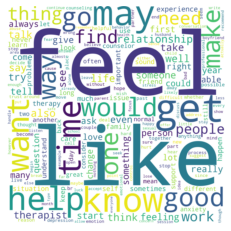

In [60]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=2000, height=2000, background_color = 'white',min_font_size=20)
wordcloud.generate_from_frequencies(frequencies=all_words)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [61]:
wordcloud.to_file('../Images/corpus.png')